In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
from statsmodels.nonparametric.smoothers_lowess import lowess

In [4]:
def get_good_files(ep_output_folder):
    # read full_output file
    full_output_file = glob(f'{ep_output_folder}/**full_output*.csv*')[0]
    df = pd.read_csv(full_output_file, skiprows=[0, 2])
    # filter for Foken flag of 0 and return raw input filenames
    df = df.query('qc_co2_flux == 0')
    good_files = df['filename'].values
    return good_files

In [5]:
good_files = get_good_files(
    r'E:\flux_data_processing\10hz_data\MOFO_understory\ep_output\13m_canopy_height')

In [6]:
def merge_good_files(good_files, ep_output_folder):

    good_spectras = pd.DataFrame()
    good_cospectras = pd.DataFrame()
    # append data from files as columns with timestamp as name
    for f in tqdm(good_files):
        pattern = f'{f[5:13]}-{f[-8:-4]}'
        # for some reason not all qc = 0 timestamps have a full_spectra file
        try:
            full_sectra_file = glob(
                f'{ep_output_folder}/eddypro_full_cospectra/*{pattern}*.csv')[0]
        except IndexError as ie:
            #print(f'no file for {pattern} found in cospectra folder. skipping timestamp.')
            continue
        df = pd.read_csv(full_sectra_file, skiprows=12, index_col=0,
                         na_values=-9999)
        df = df.dropna()
        good_spectras[pattern] = df['f_nat*spec(ts)']
        good_cospectras[pattern] = df['f_nat*cospec(w_ts)']
    return good_spectras, good_cospectras

In [7]:
good_spectras, good_cospectras = merge_good_files(
        good_files, r'E:\flux_data_processing\10hz_data\MOFO_understory\ep_output\13m_canopy_height')

100%|█████████████████████████████████████████████| 3223/3223 [02:04<00:00, 25.86it/s]


In [48]:
def plot_spectras(df, outfile=None):
    # plot data
    spectra_fig = plt.figure(1)
    # plt.plot(df.median(axis=1), 'k-', label='median spectra with QC flag 0')
    plt.plot(df.median(axis=1), 'k.', alpha=.05,
             label='median data with QC flag 0')
    # plot loess smoothed line
    smoothed = lowess(df.median(axis=1).values, df.index, is_sorted=True,
                      frac=0.01, it=0)
    plt.plot(smoothed[40:, 0], smoothed[40:, 1], 'b', label='lowess fit')
    # tweak plot
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('f (Hz)')
    plt.ylabel('spectra (T)')
    plt.legend()
    plt.tight_layout()
    # save plot if desired
    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')

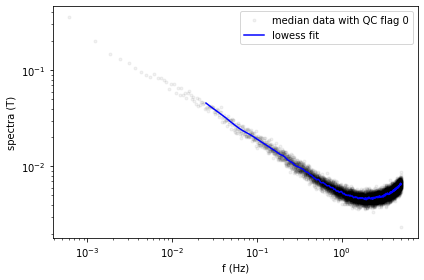

In [49]:
plot_spectras(good_spectras)

In [50]:
def plot_cospectras(df, outfile=None):
    # plot data
    cospectra_fig = plt.figure(2)
    plt.plot(df.median(axis=1), 'k.', alpha=.05,
             label='median data with QC flag 0')
    # plot loess smoothed line
    smoothed = lowess(df.median(axis=1).values, df.index, is_sorted=True,
                      frac=0.05, it=0)
    plt.plot(smoothed[:, 0], smoothed[:, 1], 'b', label='lowess fit')
    # plot ideal slope
    x = np.linspace(0.2, 5)
    y1 = .006*x**(-4/3)
    plt.plot(x, y1, 'r--', label='-4/3 slope')
    # tweak plot
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('f (Hz)')
    plt.ylabel('cospectra (w/T)')
    plt.legend()
    plt.tight_layout()
    # save plot if desired
    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')

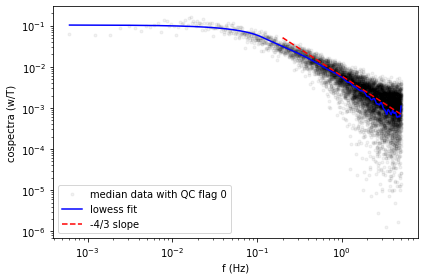

In [51]:
plot_cospectras(good_cospectras)